In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm

from dataset.synthetic import SyntheticMDPDataset
from ope.meta import OffPolicyEvaluation
from ope.estimator import TrajectoryWiseIS as TrajIS
from ope.estimator import StepWiseIS as StepIS
from utils.common import visualize_mean_squared_error
from utils.common import aggregate_simulation_results
from policy.function import gen_eps_greedy

In [2]:
# settings
H=6
n_states=50
dim_state=5
n_actions=5
beta=1.0
eps=0.3
reward_noise=1.0
random_state=12345
val_size=2000
n_sim=1000

In [3]:
sample_sizes = [1000, 2000, 3000, 4000]
ope_estimators = [
    TrajIS(estimator_name="Traj-IS"),
    StepIS(estimator_name="Step-IS")
]

In [4]:
# 1: Experiments with varying sample size in logged data. 
dataset = SyntheticMDPDataset(
    H=H,
    n_states=n_states,
    dim_state=dim_state,
    n_actions=n_actions,
    beta=beta,
    reward_noise=reward_noise,
    random_state=random_state
)
q_s_a = dataset.true_dist_dict["q_s_a"]
pi_e_a_s = gen_eps_greedy(q_s_a, eps=eps)

policy_value = dataset.calc_ground_truth_policy_value(pi_e_a_s)

result_df_list = []
for val_size in sample_sizes:
    
    result_list = []
    for _ in tqdm(range(n_sim), desc=f"val_size={val_size}"):
        
        # obtain batch data based on markov decision process(MDP).
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        
        ope = OffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators
        )
        
        estimated_policy_values = ope.estimate_policy_values(action_dist=pi_e_a_s)
        
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list, policy_value=policy_value, x_value=val_size
    )
    result_df_list.append(result_df)

result_df = pd.concat(result_df_list).reset_index(level=0)

val_size=1000: 100% 1000/1000 [00:03<00:00, 252.54it/s]
val_size=2000: 100% 1000/1000 [00:08<00:00, 122.08it/s]
val_size=3000: 100% 1000/1000 [00:10<00:00, 92.44it/s]
val_size=4000: 100% 1000/1000 [00:14<00:00, 69.24it/s]


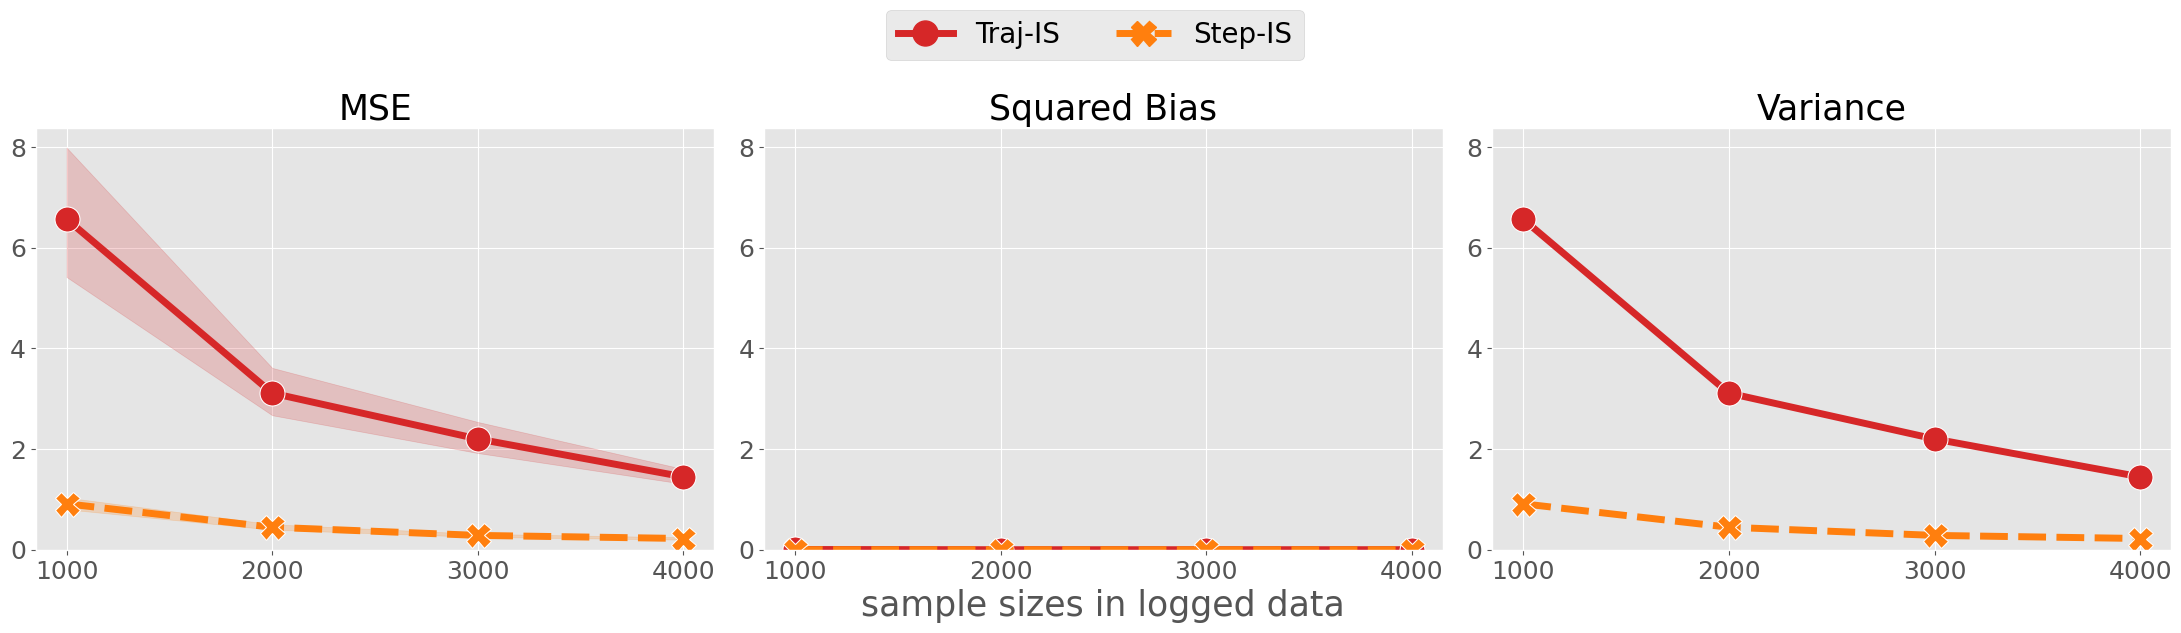

In [5]:
visualize_mean_squared_error(
    result_df=result_df,
    xlabel="sample sizes in logged data",
    yscale="linear"
)

In [8]:
# 2: Experiments with varying length of trajectory. 

H_list = [2, 4, 6, 8]

result_df_list = []
for H in H_list:
    
    dataset = SyntheticMDPDataset(
        H=H,
        n_states=n_states,
        dim_state=dim_state,
        n_actions=n_actions,
        beta=beta,
        reward_noise=reward_noise,
        random_state=random_state
    )
    q_s_a = dataset.true_dist_dict["q_s_a"]
    pi_e_a_s = gen_eps_greedy(q_s_a, eps=eps)

    policy_value = dataset.calc_ground_truth_policy_value(pi_e_a_s)
    
    result_list = []
    for _ in tqdm(range(n_sim), desc=f"H={H}"):
        
        # obtain batch data based on markov decision process(MDP).
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        
        ope = OffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators
        )
        
        estimated_policy_values = ope.estimate_policy_values(action_dist=pi_e_a_s)
        
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list, policy_value=policy_value, x_value=H
    )
    result_df_list.append(result_df)

result_df = pd.concat(result_df_list).reset_index(level=0)

H=2: 100% 1000/1000 [00:04<00:00, 208.11it/s]
H=4: 100% 1000/1000 [00:09<00:00, 104.31it/s]
H=6: 100% 1000/1000 [00:14<00:00, 69.31it/s]
H=8: 100% 1000/1000 [00:19<00:00, 52.10it/s]


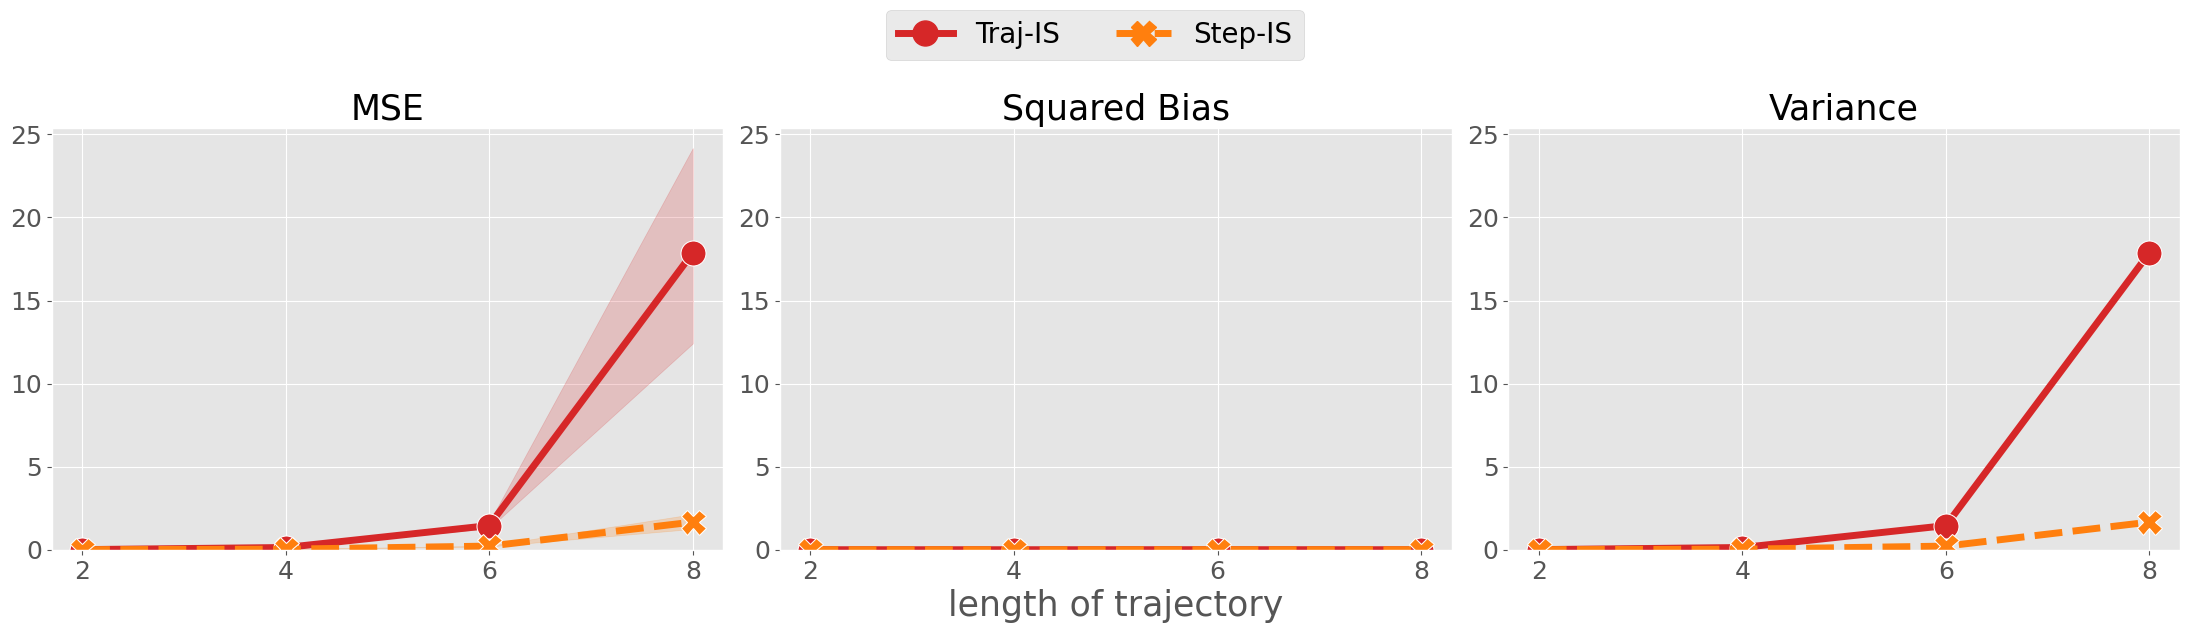

In [9]:
visualize_mean_squared_error(
    result_df=result_df,
    xlabel="length of trajectory",
    yscale="linear"
)